__Predicting Bike Rental Volumes using the scikit-learn [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor)__

We will use varying parameters - such as time of day, season and the weather - to predict the number of bike rentals made in a given hour on the communal bike sharing stations Washington, D.C.

The number of bike rentals that could be made in a given hour are assumed to be continuous which is why the _RandomForestRegressor_ is used instead of the _RandomForestClassifier_ - the latter being more suitable for predicting category classifications. Furthermore, the majority of input parameters are also continuous so the _RandomForestRegressor_ should be expected to perform well.  

The data set used is the [Bike Sharing Dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) made available on the University of California, Irvine's website. 

# Data set inspection

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

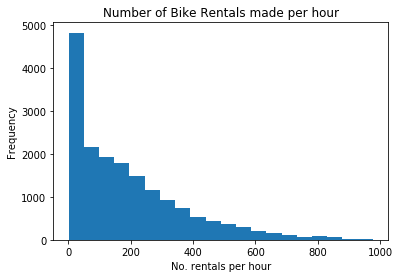

In [2]:
bike_rentals['cnt'].plot.hist(bins=20)
plt.title('Number of Bike Rentals made per hour')
plt.xlabel('No. rentals per hour')

bike_rentals.describe()['cnt']

The distribution of rentals is very smooth, with the execption of the 0-50 rentals per hour bin - which is more than double the next bin. Therefore most of the time there are only a small number of rentals, but a smooth distribution suggests that we can readily predict the number of rental as the parameters change. The next step is to check for obvious correlations:

In [3]:
cnt_corr = bike_rentals.corr()['cnt']
cnt_corr.sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

The two most well correlated columns __casual__ and __registered__ do not count. These two columns sum together to the total __cnt__ and will need to be ignored - from the data set description:

__casual__ : _The number of casual riders (people who hadn't previously signed up with the bike sharing program)_
__registered__ : _The number of registered riders (people who had already signed up)_

__temp__ _The temperature, on a 0-1 scale_ and __atemp__ _The adjusted temperature_ correlate well, but plausibly one will need to be removed if they are really only just proxies for each other. __hum__ _The humidity, on a 0-1 scale_ likely also correlates with temperature. 

__hr__ _The hour the rentals occurred_ also correlates well, suggesting we'll see peak & low times of day. 

__instant__ - A unique sequential ID number for each row will also need to be dropped. 

__dteday__ - _The date of the rentals_. This is no use for predicting future dates and we are already supplied with __mnth__ and __season__ - each show a weak correlation. Therefore __dteday__ will also be dropped.

_holiday,_ _weekday,_ _workingday_ have a very weak correlation and may yet be ignored. Although it could be assumed that there should be some pattern, say if most users ride to work or the bikes are popular with tourists. This will require further investigation.

In [4]:
invalid_cols = ('instant','cnt','casual','registered','dteday')
cols_to_drop = list(invalid_cols)

# Data set enhancement

The __hr__ column contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. Therefore we can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

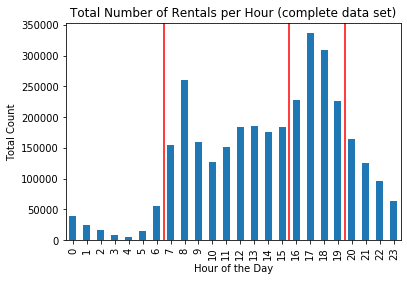

In [5]:
def group_sum_count(df,col):
    '''Group a target column and sum the count'''
    return df[[col,'cnt']].groupby([col]).sum()
        
def plot_total_counts(df_grouped,title,x_label,lines=[],xticklabels=[]):
    '''Visualise the distribution of target parameters. 
    Use lines to visual possible groupings'''
    
    ax = df_grouped.plot.bar(legend=None)
    
    plt.title('Total Number of Rentals {}'.format(title))
    plt.xlabel(x_label)
    plt.ylabel('Total Count')

    if len(xticklabels):
        ax.set_xticklabels(xticklabels)
    
    for line in lines:
        plt.axvline(line,c='red')
                    
grouped_hrs = group_sum_count(bike_rentals,'hr') 
plot_total_counts(grouped_hrs,'per Hour (complete data set)','Hour of the Day',lines=[6.5,15.5,19.5])

The __Hour__ can be grouped into 4 segments; 1. Early morning (low), 2. Middle of the day (high), 3. Late Afternoon-Evening (very high), 4. Night (low). First, we can group these times into the above groupings:

In [6]:
def assign_label(val,pairs):
    '''Itemise an input value'''
    for (key, ret) in pairs.items():
        if val <= key:
            return ret

    raise ValueError('Pairs out of range')    

pairs = {6:4, 15:1, 19:2, 24:3}       
bike_rentals['time_label'] = bike_rentals.apply(lambda x: assign_label(x['hr'],pairs), axis=1)    

There is also a clear 8am peak. Plausibly this might group with _weekday_ and represent a pre-work rush hour. The same might be true for the _Late Afternoon-Evening_ segment. This warrants further investigation. 

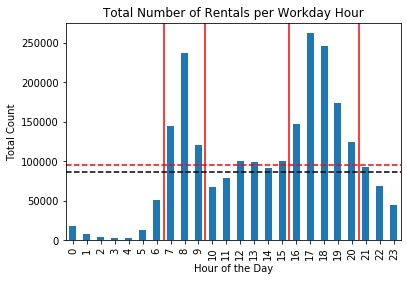

In [7]:
# Select workdays, then group by hour
grouped_workday_hrs = group_sum_count(bike_rentals[bike_rentals['workingday'] == 1],'hr')
plot_total_counts(grouped_workday_hrs,'per Workday Hour','Hour of the Day',lines=[6.5,9.5,15.5,20.5])
# plot the mean of the grouped hr/counts
plt.axhline(grouped_workday_hrs['cnt'].mean(),color='red',linestyle='dashed')

# note: the 'max' non-workday counts are lower than the mean of the workday counts, so all 
# non-workdays will all be considered off peak.
grouped_non_workday_hrs = group_sum_count(bike_rentals[bike_rentals['workingday'] == 0],'hr')
plt.axhline(grouped_non_workday_hrs['cnt'].max(),color='black',linestyle='dashed')

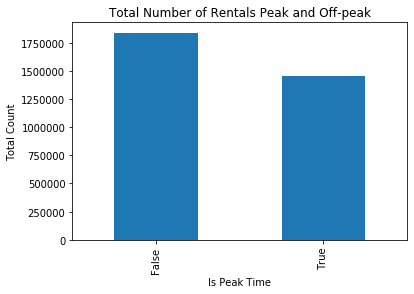

In [8]:
# set the peak_time 
bk_workday = bike_rentals['workingday'] == 1
bk_morning = (bike_rentals['hr'] >= 7 ) & (bike_rentals['hr'] <= 9 ) # morning peak
bk_evening = (bike_rentals['hr'] >= 16) & (bike_rentals['hr'] <= 20) # afternoon peak

bike_rentals['peak_time'] = (bk_workday & ( bk_morning | bk_evening ))

grouped_hrs = group_sum_count(bike_rentals,'peak_time') 
plot_total_counts(grouped_hrs,'Peak and Off-peak','Is Peak Time')

Both __peak_time__ and __time_label__ correlate with the rental count more strongly than do __hr__ (0.394) or __workingday__ (0.030) individually. Furthermore, there is only a borderline correlation between these two new columns and only a reasonable correlation between them and the original columns. 

In [9]:
bike_rentals[['peak_time','time_label','hr','workingday','cnt']].corr()

,peak_time,time_label,hr,workingday,cnt
peak_time,1.000000,-0.268211,0.213915,0.371539,0.526853
time_label,-0.268211,1.000000,-0.353038,-0.000775,-0.511113
hr,0.213915,-0.353038,1.000000,0.002285,0.394071
workingday,0.371539,-0.000775,0.002285,1.000000,0.030284
cnt,0.526853,-0.511113,0.394071,0.030284,1.000000


As mentioned, Temperature correlates well with the number of rentals. However given that they correlate almost perfectly, __temp__ and __atemp__ are indeed proxies of one another. __temp__ correlates slightly better with the count so __atemp__ will be dropped.

,atemp,temp,cnt
atemp,1.000000,0.987672,0.400929
temp,0.987672,1.000000,0.404772
cnt,0.400929,0.404772,1.000000


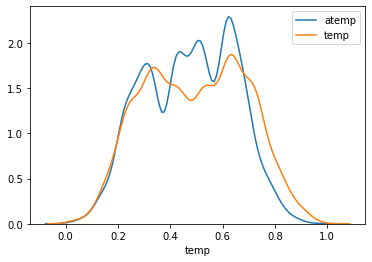

In [10]:
sns.distplot(bike_rentals['atemp'], bins=[], label='atemp', hist=False)
sns.distplot(bike_rentals['temp'], bins=[], label='temp', hist=False)

cols_to_drop.append('atemp') # drop atemp

bike_rentals[['atemp','temp','cnt']].corr()

__temp__ - _Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)_ 

Temperature is very, very granular. It should be regrouped into itemised bins before grouping and summing as was done with _hour_.

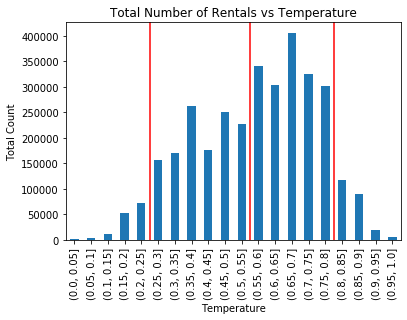

In [11]:
def bin_continuous_var(df,col,bins=np.arange(0,1.05,0.05)):
    '''bin/"pre-group" a continuous variable into bins to aid plotting'''
    return pd.concat([df[['cnt']], pd.cut(df[col],bins)],axis=1) 
    
grouped_tmp = group_sum_count(bin_continuous_var(bike_rentals,'temp'),'temp') 
plot_total_counts(grouped_tmp,'vs Temperature','Temperature',lines=[4.5,10.5,15.5]) # specified lines are arbitrary

In [12]:
pairs = {0.25:1, # cold
         0.55:2, # temperate
         0.8:3,  # warm 
         1.:4}   # hot    
    
bike_rentals['temp_label'] = bike_rentals.apply(lambda x: assign_label(x['temp'],pairs), axis=1)
cols_to_drop.append('temp') # now drop temp 

The temperature clearly has an effect, people like cycling when it is warm but not too hot (assumed that 0 is cold and 1 is hot). Therefore the weather in general likely has an (unsurprisingly) big impact. 

__weathersit__ - _The weather (as a categorical variable)._ 

    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

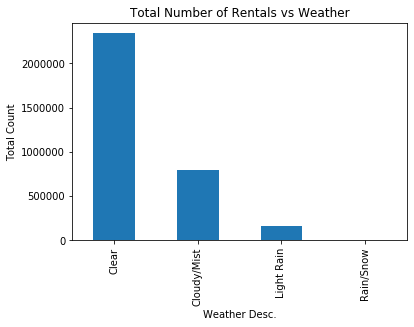

In [13]:
grouped_wth = group_sum_count(bike_rentals,'weathersit') 
plot_total_counts(grouped_wth,'vs Weather','Weather Desc.',xticklabels=['Clear','Cloudy/Mist','Light Rain','Rain/Snow'])

__hum__ - _The humidity, on a 0-1 scale_. Was negatively correlated (-0.32) with rental count. This continuous variable should also be grouped. 

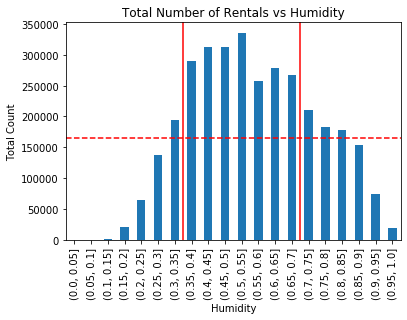

In [14]:
grouped_hum = group_sum_count(bin_continuous_var(bike_rentals,'hum'),'hum') 
plot_total_counts(grouped_hum,'vs Humidity','Humidity',lines=[6.5,13.5]) # specified lines are arbitrary
plt.axhline(grouped_hum['cnt'].mean(),color='red',linestyle='dashed')

In [15]:
pairs = {0.35:1, # low humidity
         0.70:2, # moderate
         1.:3}   # high

bike_rentals['humidity_label'] = bike_rentals.apply(lambda x: assign_label(x['hum'],pairs), axis=1)
cols_to_drop.append('hum') # now drop hum 

__windspeed__ - _The wind speed, on a 0-1 scale_. Wind speed had a weak correlation (0.093) but being the last continuous column it will be grouped anyway.

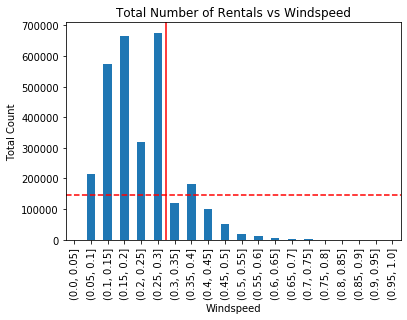

In [16]:
grouped_wind = group_sum_count(bin_continuous_var(bike_rentals,'windspeed'),'windspeed') 
plot_total_counts(grouped_wind,'vs Windspeed','Windspeed',lines=[5.5]) # specified lines are arbitrary
plt.axhline(grouped_wind['cnt'].mean(),color='red',linestyle='dashed')

In [17]:
pairs = {0.3:0, # low          
         1.:3}  # windy

bike_rentals['wind_label'] = bike_rentals.apply(lambda x: assign_label(x['windspeed'],pairs), axis=1)
cols_to_drop.append('windspeed') # now drop hum 

# Final variable selection

Both __mnth__ - _The month the rentals occurred,_ and __season__ - _The season in which the rentals occurred_ have a weak correlation (0.121 and 0.178 respectively). There is another unsuprising pattern in that winter months are less popular than the rest of the year. Both variables will in the set remain as-is; __Season:__ 1:winter, 2:spring, 3:summer, 4:fall and __mnth:__ 1 to 12.

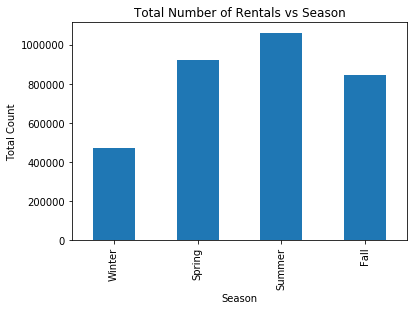

In [18]:
grouped_season = group_sum_count(bike_rentals,'season') 
plot_total_counts(grouped_season,'vs Season','Season', xticklabels=['Winter','Spring','Summer','Fall'])

__yr__ - _The year the rentals occurred_ , is a more complicated choice. There is a reasonable correlation (0.25) and only two values; 0 and 1 as there is only two years worth of data and the volume has almost doubled between years. 

It's not clear how helpful this field will be for future predictions. It might suggests that the bikes have become more popular with time, or there are simply more of them. There is no guarantee that such trends will continue. 

However keeping this field should help split the tree by removing any noise from the clear variation between years in the set and therefore emphasising other relationships. 

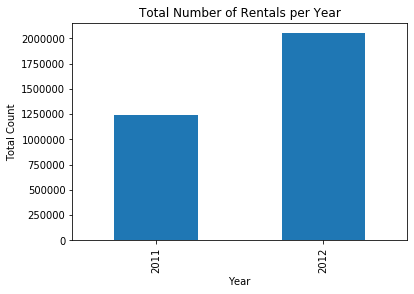

In [19]:
grouped_season = group_sum_count(bike_rentals,'yr') 
plot_total_counts(grouped_season,'per Year','Year', xticklabels=['2011','2012'])

In [20]:
def get_target_cols(df,cols_to_drop):
    '''Final parameters to fit'''
    
    return df.loc[:,~df.columns.isin(cols_to_drop)].columns
    
target_cols = get_target_cols(bike_rentals,cols_to_drop)
target_cols.tolist()

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'time_label',
 'peak_time',
 'temp_label',
 'humidity_label',
 'wind_label']

# The DecisionTreeRegressor

Decision Trees can yield some of the best predictive results of any machine learning models. However they are very prone to overfitting - for example, a tree could be created that has enough depth and splits that each row in the training set has its own leaf in the tree. Such a tree would capture all possible scenarios but may overfit any randomness within the data set. The predictive capabilites may therefore not extend so well to previously unseen data. 

## Measuring the fit 
A Root mean squared error (RMSE) is suitable for measuring the model fit. As per the _Number of Bike Rentals made per hour_ histogram, the distribution is continuous and very smooth. RMSE has the benefit of penalising large errors which is suitable given that some of the correlations we have seen a weak. 

The data set will be split into two; training (80%) and test (20%) data so there will be no requirement to compare results between models of differing sample sizes. For example, RMSE has a tendency to be increasingly larger than Mean Absolute Error (MAE) as the test sample size increases. 

Two of the parameters within the [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) model are very useful in preventing an overfit. These are 1. __min_samples_leaf__; _The minimum number of samples required to split an internal node,_ and 2. __max_depth__; _The maximum depth of the tree._

We will produce an RMSE score for varying values of __min_samples_leaf__ and __max_depth__. 

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# randomise the data set and then split into test/training data. 
train = bike_rentals.sample(int(bike_rentals.shape[0]*.8),random_state=17)  # 80% of the set
test  = bike_rentals[~bike_rentals.index.isin(train.index)] # test rows != training 
train.shape[0], test.shape[0], bike_rentals.shape[0]

(13903, 3476, 17379)

In [22]:
def fit_tree(Tree,train,test,predictor_cols,test_col,min_samples_leaf=0,max_depth=0):
    '''Fits a DecisionTreeRegressor to training & test data. Predict results on both sets.
    Score RMSE on both for comparison.'''
    # init model
    DT = Tree(min_samples_leaf=min_samples_leaf,max_depth=max_depth,random_state=1)
    # fit
    DT.fit(train[predictor_cols],train[test_col])

    # predict the test results
    test_predictions = DT.predict(test[predictor_cols])
    # also predict results on the trainning data for comparison
    train_predictions= DT.predict(train[predictor_cols])    

    # score both
    test_rmse = mean_squared_error(test[test_col],test_predictions)**.5
    train_rmse= mean_squared_error(train[test_col],train_predictions)**.5    
    
    return train_rmse, test_rmse

In [23]:
def plot_leaf_and_depth_rmse(Tree,train,test,predictor_cols,test_col='cnt',max_depths=[],min_samples=[],bubble_scale=5):
    '''Loop over various max_depths and min_samples to fit & test a Decision Tree. Score and 
    plot the RMSEs as a Bubble plot. Smaller bubbles mean smaller RMSE scores, and hence a better fit. 
    '''    
    test_rmses = []
    train_rmses= []
    for min_sample in min_samples:
        for max_depth in max_depths:
            # fit and score the model
            train_rmse, test_rmse = fit_tree(Tree,train,test,target_cols,test_col,
                                              min_samples_leaf=min_sample, max_depth=max_depth)
            # collect the scores vs parameters
            test_rmses.append([min_sample,max_depth,test_rmse])
            train_rmses.append([min_sample,max_depth,train_rmse])

    # convert to numpy for easy splitting
    test_rmses = np.array(test_rmses)
    train_rmses= np.array(train_rmses)

    # Min RMSEs yield best model
    best_train = train_rmses[train_rmses[:,2].min() == train_rmses[:,2]]
    best_test  = test_rmses[test_rmses[:,2].min() == test_rmses[:,2]]
    
    # plot all values
#     plt.scatter(test_rmses[:,0], test_rmses[:,1], s=test_rmses[:,2]*bubble_scale, alpha=0.2, c='black')
    plt.scatter(train_rmses[:,0], train_rmses[:,1], s=train_rmses[:,2]*bubble_scale, alpha=0.2, c='black')
    plt.scatter(best_test[:,0],  best_test[:,1],  s=best_test[:,2]*bubble_scale,  alpha=0.75, c='red') # best test RMSE
    plt.scatter(best_train[:,0], best_train[:,1], s=best_train[:,2]*bubble_scale, alpha=0.75, c='blue')# best train RMSE

    plt.title('Bubble chat depicting RMSE scores from varying Decision Trees')
    plt.xlabel('min_samples_leaf')
    plt.ylabel('max_depth')    

    plt.legend(['Train RMSEs','Best Test RMSE','Best Train RMSE'],bbox_to_anchor=(1,1))   

    # Print train results
    print( 'The best Train Data RMSE score {0:.1f} was derived using min_samples_leaf: {1}, max_depth: {2}'.format(
        best_train[:,2][0],best_train[:,0][0],best_train[:,1][0]))
    
    test_rmse_from_train = test_rmses[(test_rmses[:,0] == best_train[:,0][0]) &
                                      (test_rmses[:,1] == best_train[:,1][0])]
    
    print( '-> The test RSME score {0:.1f} derived using Best Train (min_samples_leaf: {1}, max_depth: {2}) variables.'.format(
        test_rmse_from_train[:,2][0],best_train[:,0][0],best_train[:,1][0]))

    # Print test results
    print( '\nThe best Test Data  RMSE score {0:.1f} was derived using min_samples_leaf: {1}, max_depth: {2}'.format(
        best_test[:,2][0],best_test[:,0][0],best_test[:,1][0]))    

    train_rmse_from_test = train_rmses[(train_rmses[:,0] == best_test[:,0][0]) &
                                       (train_rmses[:,1] == best_test[:,1][0])]    
    
    print( '-> The train RSME score {0:.1f} derived using Best Test (min_samples_leaf: {1}, max_depth: {2}) variables.'.format(
        train_rmse_from_test[:,2][0],best_test[:,0][0],best_test[:,1][0]))

The best Train Data RMSE score 28.1 was derived using min_samples_leaf: 2.0, max_depth: 30.0
-> The test RSME score 53.7 derived using Best Train (min_samples_leaf: 2.0, max_depth: 30.0) variables.

The best Test Data  RMSE score 49.5 was derived using min_samples_leaf: 5.0, max_depth: 20.0
-> The train RSME score 39.1 derived using Best Test (min_samples_leaf: 5.0, max_depth: 20.0) variables.


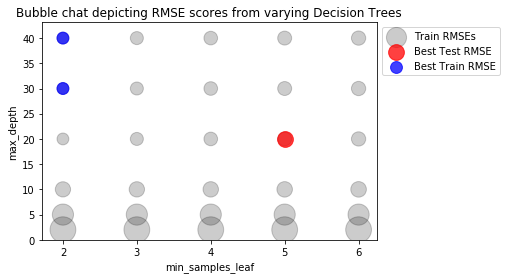

In [24]:
max_depths = [2,5,10,20,30,40]
min_samples = [2,3,4,5,6]

# Build and plot results of a DecisionTreeRegressor 
plot_leaf_and_depth_rmse(DecisionTreeRegressor,train,test,target_cols,
                         test_col='cnt',max_depths=max_depths,min_samples=min_samples)

The (two) best fits from the predictions on the training set are found using very different Decision Tree parameters than those of the test set. This is not too surprising. 

As mentioned, Decision Trees are prone to overfitting. It is highly likely that the best fit for a decision tree that is trained, tested and scored on the same data set would be one that covers every possible scenario. 

As seen above, the continuous parameters were removed from the data and replaced with itemised equivalents. That the _min_samples_leaf = 2_ (The minimum number of samples required to split an internal node) yielded the best fit suggests that the tree indeed kept splitting until all scenarios were covered. Once the _max_depth_ is large enough to cover all scenarios, increasing it further cannot yield better results - hence the two best fits at _max_depth_ = 30 & 40. 

Therefore it should be expected that when applied to previously unseen test data, the same model loses some of its predictive power. Indeed the test data RMSE (53.7) derived using the model attributes of the best fit train data is almost twice as large as the train RMSE (28.1). Whereas the spread between the test RMSE (49.5) and the train RMSE (39.1), as derived from the best fit test data, is much narrower. 

Finally, it should be expected that lower values of _max_depth_ yield larger RMSEs - hence the bigger bubbles in the plot. If the tree has not been exhausted then even the training data set will struggle to yield accurate predictions. 


# The RandomForestRegressor

The [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor) model produces a diverse set of classifiers created by introducing randomness in the classifier construction. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors and by taking an average of those predictions, some errors can cancel out. For this reason they tend to overfit much less than decision trees. 

The best Train Data RMSE score 31.7 was derived using min_samples_leaf: 2.0, max_depth: 30.0
-> The test RSME score 46.9 derived using Best Train (min_samples_leaf: 2.0, max_depth: 30.0) variables.

The best Test Data  RMSE score 46.9 was derived using min_samples_leaf: 2.0, max_depth: 20.0
-> The train RSME score 31.8 derived using Best Test (min_samples_leaf: 2.0, max_depth: 20.0) variables.


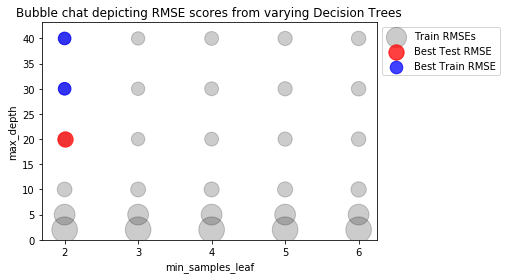

In [25]:
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore') # Deprecation Warnings

# Build and plot results of a RandomForestRegressor 
plot_leaf_and_depth_rmse(RandomForestRegressor,train,test,target_cols,
                         test_col='cnt',max_depths=max_depths,min_samples=min_samples)

The __RandomForestRegressor__ has produced a slightly better RMSE score on the test data in comparision to the __DecisionTreeRegressor__. Furthermore, that the RandomForestRegressor also yields a larger RMSE score on the training data suggests that indeed the RandomForestRegressor is less prone to overfitting than the DecisionTreeRegressor.

# Comparison to other models

The __RandomForestRegressor__ model was expected to perform well on this task; the number of humans making a decision to rent a bike based upon optimal weather conditions - e.g. not too cold, but not too hot - is a very plausible scenario. 

However to see just how well this model worked we can compare it to other machine learning models. __LinearRegression__ is a suitable model because the result - the number of rentals per hour - can be assumed to be continous and many of the input parameters correlate well with the value we wish to predict. 

In [26]:
from sklearn.linear_model import LinearRegression

def fit_LinearRegression(train,test,predictor_cols,test_col):
    '''Fit a LinearRegression model. Print the RMSE'''    
    # fit
    lr = LinearRegression()
    lr.fit(train[predictor_cols],train[test_col])
    # predict
    test_predictions = lr.predict(test[predictor_cols])
    train_predictions= lr.predict(train[predictor_cols])
    # score
    test_rmse = mean_squared_error(test[test_col],test_predictions)**0.5
    train_rmse= mean_squared_error(train[test_col],train_predictions)**0.5

    print('test RMSE:  {:.2f}'.format(test_rmse))
    print('train RMSE: {:.2f}'.format(train_rmse))

In [27]:
fit_LinearRegression(train,test,target_cols,'cnt')

test RMSE:  105.24
train RMSE: 107.96


The _LinearRegression_ model has yielded RMSEs more than twice as large as the _RandomForestRegressor_. However this is not yet a like-for-like comparison. 

Decision Trees work like a series of if/else statements, with each statement causing the next branch. Whereas the _LinearRegression_ model treats the values within each column as a continous distribution. For example, in the above LR model, Winter (1) is treated as _less than_ Summer (3), which does not make sense. 

_One-hot encoding_ can be used to resolve this. Individual _dummy columns_ are created for each disinct value contained within a column - i.e. four separate _season_ columns - containing Zero or One for the applicable value.

One advantage of _LinearRegression_ is that the original scaled columns (e.g. __hum__) that have continous values between 0 and 1 can fit directly into the mode. We'll keep the itemised columns (e.g. __humidity_label__) for now but stay mindful of the risk of overfitting. 

In [30]:
dummy_bike = bike_rentals.copy() # leave the original DataFrame alone

dummy_cols = get_target_cols(dummy_bike,list(invalid_cols)) 
# get columns that require conversion - this ignores continous columns such as 'hum'. 
# However it will also keep the 'year' (0 or 1) column. 
dummy_cols = dummy_cols[(dummy_bike[dummy_cols].max() > 1)] 

dummy_cols 

Index(['season', 'mnth', 'hr', 'weekday', 'weathersit', 'time_label',
       'temp_label', 'humidity_label', 'wind_label'],
      dtype='object')

In [31]:
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column"""
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    
    return df.drop(columns=[column_name])

# convert the categorised columns into separate dummy columns
for col in list(dummy_cols):
     dummy_bike = create_dummies(dummy_bike,col)

In [32]:
# split the data again. 
dummy_train = dummy_bike.sample(int(dummy_bike.shape[0]*.8),random_state=17)  # 80% of the set
dummy_test  = dummy_bike[~dummy_bike.index.isin(train.index)] # test rows != training        

# get all applicable columns
dummy_target_cols = get_target_cols(dummy_bike,list(invalid_cols))

# Fit the new LinearRegression model
fit_LinearRegression(dummy_train,dummy_test,dummy_target_cols,'cnt')

test RMSE:  87.34
train RMSE: 89.66


The narrow spread between the training and test RMSEs is narrow - this suggests we have avoided overfitting. However the improved __LinearRegression__ model has still not been able to match the predictive power of the __RandomForestRegressor__. 

# Different users
So far we've been predicting the total number of bike rentals per hour. However there are two different groups; __registered,__ _The number of registered riders (people who had already signed up)_ and __casual,__ _The number of casual riders (people who hadn't previously signed up with the bike sharing program)_.

Conceivably we should be able to predict these numbers more reliably than the total number _cnt_. It's highly plausible that these are two distinct sets of riders. For example _causal_ riders might be more likely to rent a bike if the weather is nice. Whereas a _registered_ rider might be more likely to brave less than optimal weather if a rental bike is their usual mode of transport to work.

The best Train Data RMSE score 25.7 was derived using min_samples_leaf: 2.0, max_depth: 30.0
-> The test RSME score 38.3 derived using Best Train (min_samples_leaf: 2.0, max_depth: 30.0) variables.

The best Test Data  RMSE score 37.9 was derived using min_samples_leaf: 4.0, max_depth: 30.0
-> The train RSME score 31.1 derived using Best Test (min_samples_leaf: 4.0, max_depth: 30.0) variables.


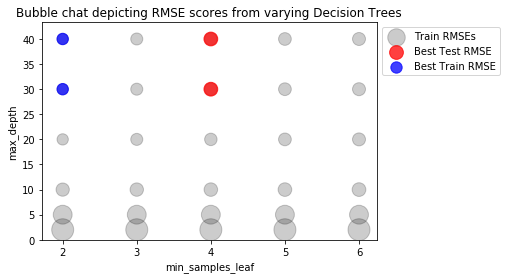

In [33]:
# Predictions for the number of rentals per hours from 'registered' users
plot_leaf_and_depth_rmse(RandomForestRegressor,train,test,target_cols,
                         test_col='registered',max_depths=max_depths,min_samples=min_samples)

The best Train Data RMSE score 11.7 was derived using min_samples_leaf: 2.0, max_depth: 30.0
-> The test RSME score 17.2 derived using Best Train (min_samples_leaf: 2.0, max_depth: 30.0) variables.

The best Test Data  RMSE score 17.1 was derived using min_samples_leaf: 3.0, max_depth: 30.0
-> The train RSME score 13.1 derived using Best Test (min_samples_leaf: 3.0, max_depth: 30.0) variables.


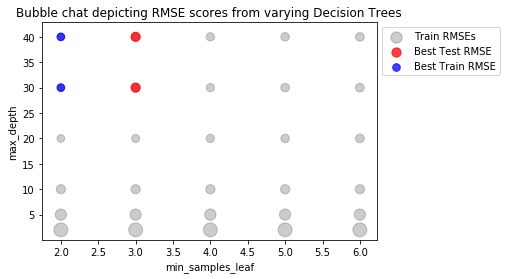

In [34]:
# Predictions for the number of rentals per hours from 'casual' users
plot_leaf_and_depth_rmse(RandomForestRegressor,train,test,target_cols,
                         test_col='casual',max_depths=max_depths,min_samples=min_samples)